<a href="https://colab.research.google.com/github/Kabilan108/experiments/blob/main/notebooks/fastai.course/00-is-it-afrobeats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Is it afrobeats?

Here, I'm fine-tuning resnet to classify spectrograms as either 'rock' or 'afrobeats'. The model is fine tuned on a dataset of ~2k images (~900 afrobeats songs and ~1.1k rock songs).

In [5]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [6]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai



1. Load dataset from HuggingFace
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on some spectrograms and see if it works.

## Step 1: Load HF dataset

In [49]:
# Skip this cell if you already have duckduckgo_search installed
!pip install -Uqq duckduckgo_search datasets==2.16.0 librosa scdl

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [11]:
from datasets import load_dataset
from fastai.vision.all import *
import matplotlib.pyplot as plt

ds = load_dataset("Kabilan108/spectrograms", split="train", trust_remote_code=True)

Generating train split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Now, take a look at some images

In [13]:
# prompt: print out images, one for each class in the dataset

classes = ds.features['label'].names
examples = {class_: [] for class_ in classes}

for example in ds:
    examples[classes[example['label']]].append(example)

examples = {c: e[0] for c, e in examples.items()}

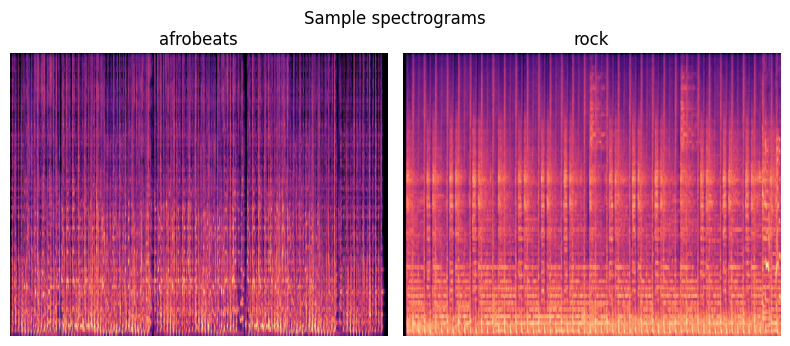

In [15]:
fig, axes = plt.subplots(1, len(examples), figsize=(8, 4))
fig.suptitle("Sample spectrograms", y=0.92)
for ax, (cl, ex) in zip(axes, examples.items()):
    ax.imshow(Image.open(ex['image']))
    ax.set_title(cl)
    ax.set_axis_off()
plt.tight_layout()

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [17]:
from datasets import Dataset
from PIL import Image
import io

def verify_images(dataset):
    valid_indices = []
    invalid_indices = []

    # Iterate over the dataset and try to open each image
    for i, example in enumerate(dataset):
        try:
            # Since the image is already a PngImageFile, we can just verify directly
            img = Image.open(example['image'])  # This will actually load the image data and verify it's complete

            # If successful, add the index to valid_indices
            valid_indices.append(i)
        except Exception as e:
            # If an error occurs, add the index to invalid_indices
            print(f"Invalid image at index {i}: {e}")
            invalid_indices.append(i)

    # Create a new dataset without the invalid images
    valid_dataset = dataset.select(valid_indices)

    return valid_dataset, invalid_indices

clean_ds, invalid_images = verify_images(ds)
print(f"{len(invalid_images)} invalid images")

0 invalid images


To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

In [33]:
img = PILImage.create(examples['rock']['image'])

In [34]:
import rich

rich.inspect(img)

╭───────────────────────────────────── <class 'fastai.vision.core.PILImage'> ─────────────────────────────────────╮
│ A RGB Pillow `Image` that can show itself and converts to `TensorImage`                                         │
│                                                                                                                 │
│ ╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ PILImage mode=RGB size=640x480                                                                              │ │
│ ╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                                                 │
│             aspect = 1.3333333333333333                                                                         │
│             format = None                                                                                       │
│ format_description = None                                                                                       │
│             height = 480                                                                                        │
│                 im = <ImagingCore object at 0x7febf5aecad0>                                                     │
│               info = {                                                                                          │
│                          'Software': 'Matplotlib version3.8.2, https://matplotlib.org/',                        │
│                          'dpi': (99.9998, 99.9998)                                                              │
│                      }                                                                                          │
│               mode = 'RGB'                                                                                      │
│               n_px = 307200                                                                                     │
│            palette = None                                                                                       │
│           pyaccess = None                                                                                       │
│           readonly = 0                                                                                          │
│              shape = (480, 640)                                                                                 │
│               size = (640, 480)                                                                                 │
│              width = 640                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [37]:
from pathlib import Path

Path(examples['rock']['image']).parent.name

'rock'

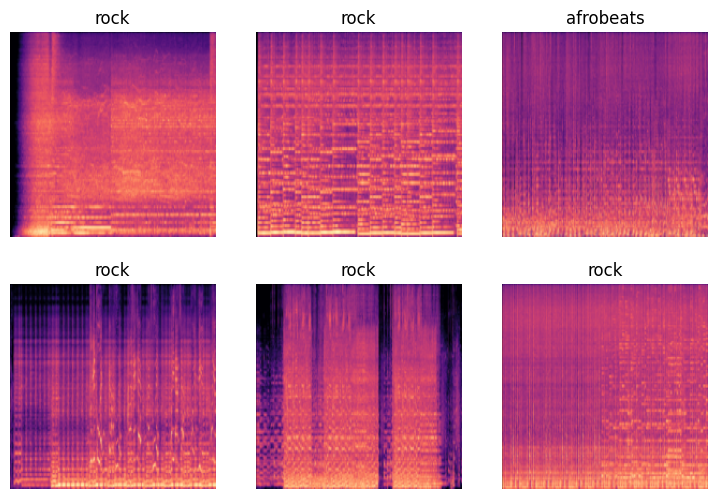

In [40]:
def get_x(r): return [ex['image'] for ex in r]
def get_y(r): return Path(r).parent.name


dbk = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_x,
    splitter=RandomSplitter(valid_pct=0.2, seed=69),
    get_y=get_y,
    item_tfms=[Resize(192, method='squish')]
)

dls = dbk.dataloaders([clean_ds[i] for i in range(len(clean_ds))])

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [43]:
learn = vision_learner(dls, resnet18, metrics=[error_rate, accuracy])
learn.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.608126,0.389143,0.118227,0.881773,00:19


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.258568,0.192067,0.059113,0.940887,00:21
1,0.146579,0.138448,0.034483,0.965517,00:20
2,0.088324,0.127051,0.032020,0.967980,00:23
3,0.057438,0.153974,0.029557,0.970443,00:19
4,0.039732,0.128263,0.024631,0.975369,00:21
5,0.026019,0.146516,0.032020,0.967980,00:20
6,0.016267,0.156566,0.034483,0.965517,00:21
7,0.010834,0.145982,0.032020,0.967980,00:19
8,0.014787,0.212747,0.039409,0.960591,00:20
9,0.025515,0.142014,0.044335,0.955665,00:20


We get a nice 97% ultimately.

## Step 3: Use the model

Next, we'll download an afrobeat song from an artist who was not included in the train/val data.

In [50]:
# download song from YouTube
!scdl -l https://soundcloud.com/dvj-ib/98-timaya-cold-outside-extended-version-dvj-ib-feat-buju-official-video

Soundcloud Downloader
Found a track
Setting tags...
98 Timaya   Cold Outside Extended version DVJ IB feat  Buju Official Video.mp3 Downloaded.



In [51]:
import librosa
import matplotlib.pyplot as plt

def create_spectrogram(audiofile: str, spectrogram_path: str) -> None:
    """Create a spectrogram from an audiofile and save it to the specified destination"""
    audiofile = Path(audiofile)
    try:
        fig, ax = plt.subplots()
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

        y, sr = librosa.load(audiofile)
        ms = librosa.feature.melspectrogram(y=y, sr=sr)
        log_ms = librosa.power_to_db(ms, ref=np.max)
        librosa.display.specshow(log_ms, sr=sr, ax=ax)

        spectrogram_path = Path(spectrogram_path)
        fig.savefig(spectrogram_path)
        plt.close(fig)
    except Exception as e:
        print(f"Failed to process {audiofile}: {e}")

create_spectrogram('/content/98 Timaya   Cold Outside Extended version DVJ IB feat  Buju Official Video.mp3', 'cold-outside.png')

In [52]:
genre,_,probs = learn.predict(PILImage.create('cold-outside.png'))
print(f"This is a: {genre} song.")
print(f"Probability it's afrobeats: {probs[0]:.4f}")

This is a: afrobeats song.
Probability it's afrobeats: 1.0000
